<a href="https://colab.research.google.com/github/bitanb1999/Depression-Detection-vs-Sentiment-Analysis/blob/main/Depression_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!pip install pytorch_transformers
!pip install seaborn
import torch
from pytorch_transformers import BertConfig,BertTokenizer,  BertModel

In [127]:
model_type = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_type)
config.output_attentions=True
model = BertModel.from_pretrained(model_type,config = config).to('cpu')
tokenizer = BertTokenizer.from_pretrained(model_type)

In [114]:
text1 = 'I am depressed I feel so terribly worthless around everyone  '
text2 = 'I speak to'
tok1 = tokenizer.tokenize(text1)
tok2 = tokenizer.tokenize(text2)

In [115]:
#visualisation of a depression class text
p_pos = len(tok1) # position for token
tok = tok1+tok2
tok,p_pos, tok[p_pos]

(['i',
  'am',
  'depressed',
  'i',
  'feel',
  'so',
  'terribly',
  'worthless',
  'around',
  'everyone',
  'i',
  'speak',
  'to'],
 10,
 'i')

In [116]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cpu')
with torch.no_grad():
    output = model(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape

torch.Size([12, 12, 13, 13])

In [117]:
attentions = attentions.permute(2,1,0,3)
print(attentions.shape)

torch.Size([13, 12, 12, 13])


In [118]:
layers = len(attentions[0][0])
heads = len(attentions[0])
seqlen = len(attentions)
layers,heads,seqlen

(12, 12, 13)

In [119]:
attentions_pos = attentions[p_pos]
attentions_pos.shape

torch.Size([12, 12, 13])

Attention weights for token i


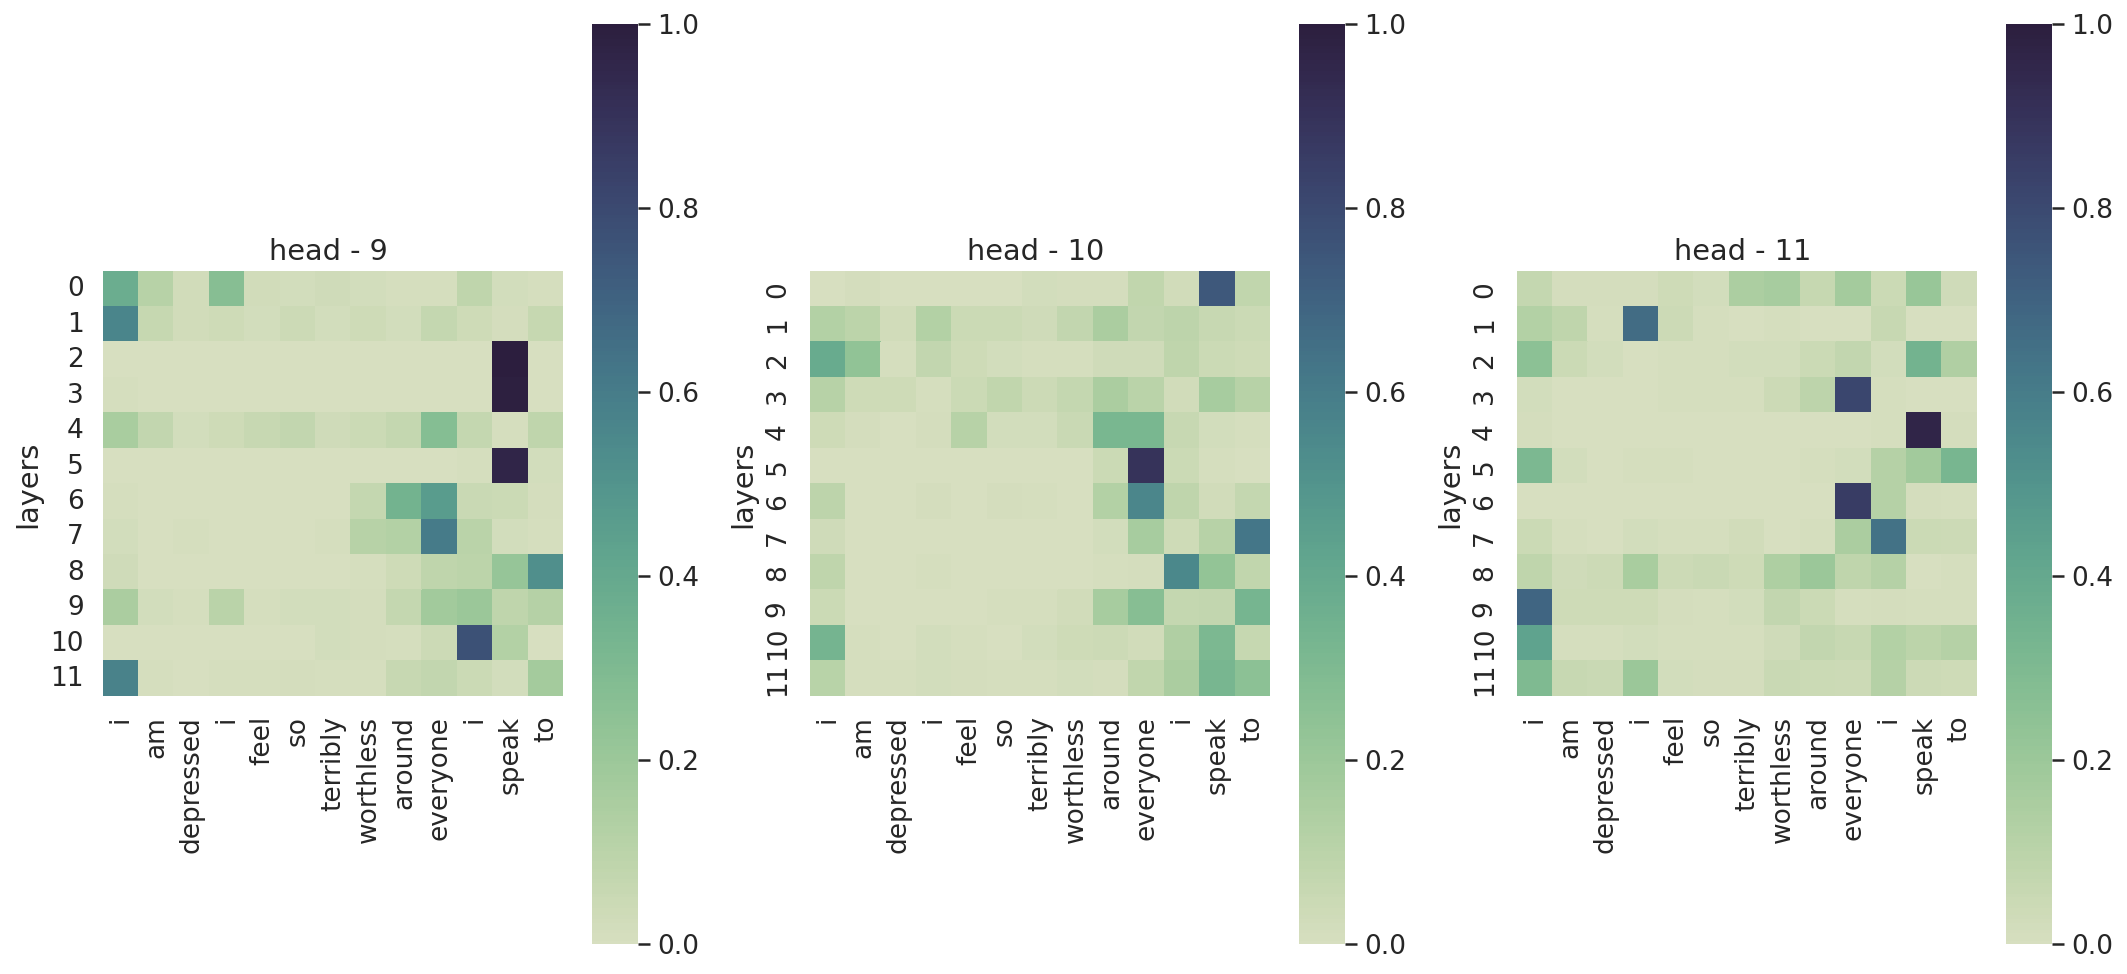

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots( 1,3, figsize = (15,7))
axes = axes.flat
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(attentions_pos[9:]):

    im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok,cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
    axes[i].set_title(f'head - {i+9} ' )
    axes[i].set_ylabel('layers')
    fig.tight_layout()
#plt.suptitle('Attention for i in a depressed class text')
plt.savefig(f'attention-{i}')


In [87]:
text1 = 'Well i am alone and  '
text2 = 'i am just wondering how everyone is doing '
tok1 = tokenizer.tokenize(text1)
tok2 = tokenizer.tokenize(text2)

In [88]:
#visualisation of no depression class
p_pos = len(tok1) # position for token
tok = tok1+tok2
tok,p_pos, tok[p_pos]

(['well',
  'i',
  'am',
  'alone',
  'and',
  'i',
  'am',
  'just',
  'wondering',
  'how',
  'everyone',
  'is',
  'doing'],
 5,
 'i')

In [89]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cpu')
with torch.no_grad():
    output = model(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape

torch.Size([12, 12, 13, 13])

In [90]:
attentions = attentions.permute(2,1,0,3)
print(attentions.shape)

torch.Size([13, 12, 12, 13])


Attention weights for token i


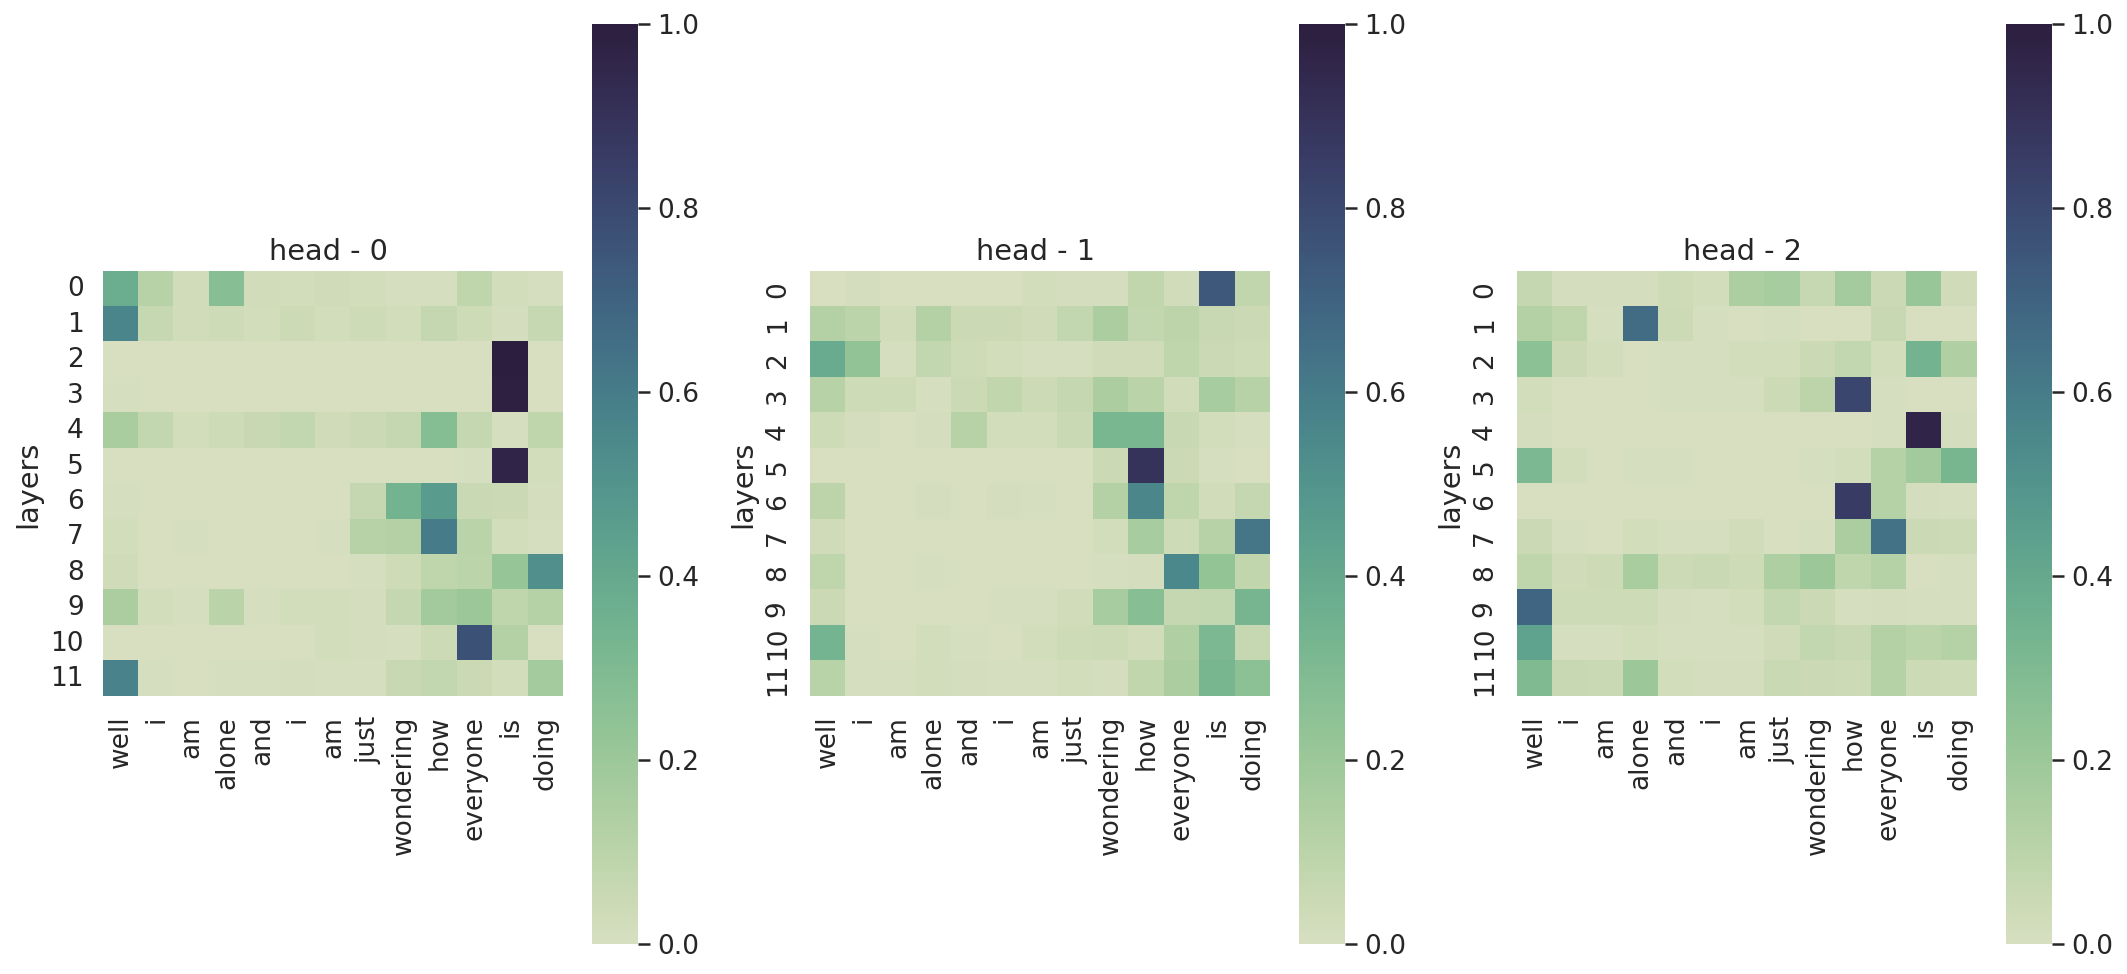

In [91]:
fig, axes = plt.subplots( 1,3, figsize = (15,7))
axes = axes.flat
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(attentions_pos[9:]):

    im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok,cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
    axes[i].set_title(f'head - {i} ' )
    axes[i].set_ylabel('layers')
    fig.tight_layout()
#plt.suptitle('Attention for i in a depressed class text')
plt.savefig(f'attention-{i}')

In [132]:
!pip install transformers pytorch-transformers
import transformers
import seaborn as sns
import numpy as np
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [133]:
#sentiment-score and labels correlation
import pandas as pd
df=pd.read_csv('/content/train.tsv',sep='\t')
df.head()

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate


In [134]:
import nltk
nltk.download('vader_lexicon')
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df['Text_data']]
df['sentiment_score'] = polarity
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,PID,Text_data,Label,sentiment_score
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate,-0.93
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate,-0.62
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate,-0.13
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate,0.98
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate,0.36


In [135]:
#visualisation of sentiment and label distribution(considering only severe and no depression)
label_dict={}
l=0;
for i in ['not depression','moderate','severe']:
  label_dict[i]=l
  l+=1
df['Label']=df['Label'].apply(lambda x:label_dict[x])
df.head()

,PID,Text_data,Label,sentiment_score
0,train_pid_1,Waiting for my mind to have a breakdown once t...,1,-0.93
1,train_pid_2,My new years resolution : I'm gonna get my ass...,1,-0.62
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,1,-0.13
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",1,0.98
4,train_pid_5,Sat in the dark and cried myself going into th...,1,0.36


In [136]:
import scipy.stats as stats
#calculate point-biserial correlation
stats.pointbiserialr(df['Label'],df['sentiment_score'])

PointbiserialrResult(correlation=-0.24574117933065973, pvalue=2.016618788565067e-122)

In [137]:
df_new=df.iloc[list(set(list(df[df.Label==2][:901].index)).union(set(list(df[df.Label==0][:901].index))))].reset_index().drop('index',axis=1)
stats.pointbiserialr(df_new['Label'],df_new['sentiment_score'])

PointbiserialrResult(correlation=-0.48890274705031495, pvalue=6.563677071073803e-109)

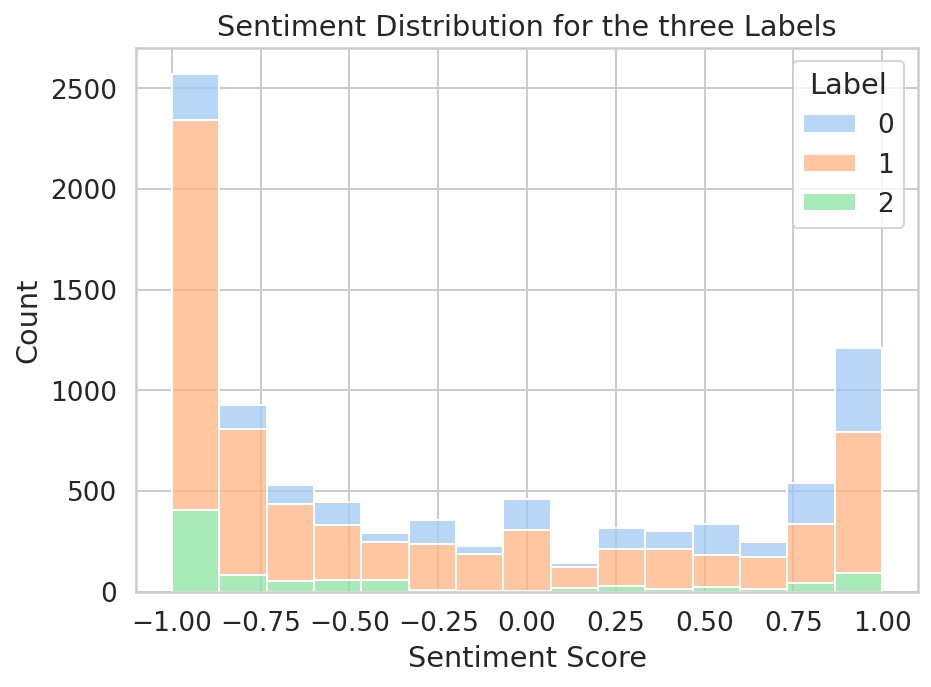

In [138]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

# mock your data frame
import numpy as np
# plot
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="sentiment_score", kde=False,
             palette="pastel", hue="Label",
             element="bars", legend=True)
#ax.set_title("Seaborn Stacked Histogram")
ax.set_xlabel("Sentiment Score")
ax.set_ylabel("Count")
plt.title('Sentiment Distribution for the three Labels')
plt.savefig('sentimentdist')

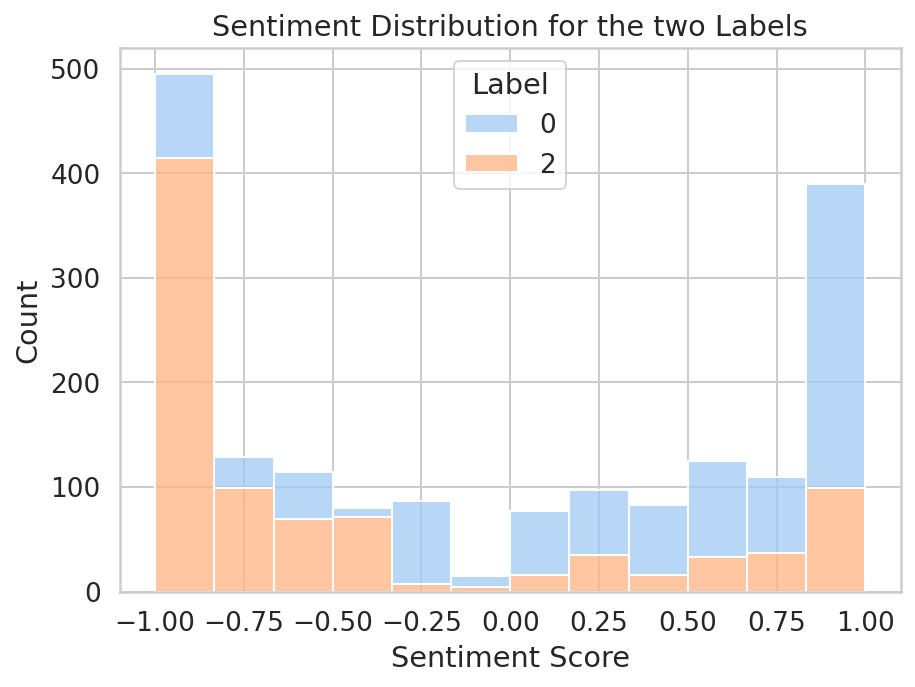

In [139]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

# mock your data frame
import numpy as np
# plot
sns.histplot(data=df_new, ax=ax, stat="count", multiple="stack",
             x="sentiment_score", kde=False,
             palette="pastel", hue="Label",
             element="bars", legend=True)
#ax.set_title("Seaborn Stacked Histogram")
ax.set_xlabel("Sentiment Score")
ax.set_ylabel("Count")
plt.title('Sentiment Distribution for the two Labels')
plt.savefig('sentimentdist2')

In [140]:
df_par=df[((df.Label==0)&(df.sentiment_score<0))|((df.Label==1)&(df.sentiment_score>0.5))|((df.Label==2)&(df.sentiment_score>0))]

In [141]:
df_par.reset_index(inplace=True,drop=True)

In [142]:
MAX_LEN = 512
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class GPSentimentDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.texts)
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [143]:
df_train, df_val = train_test_split(
  df_par[['Text_data','Label']],
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [144]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPSentimentDataset(
    texts=df.Text_data.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [145]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [146]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [147]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,return_dict=False
    )
    output = self.drop(pooled_output,)
    return self.out(output)
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [148]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [149]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [150]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [151]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [152]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

Train loss 0.7193393713849432 accuracy 0.7192723697148476


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.492170183180735 accuracy 0.7876106194690266

Epoch 2/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.3003077524568082 accuracy 0.9105211406096363


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.4671827752809522 accuracy 0.8628318584070797

Epoch 3/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.12144559611082442 accuracy 0.968534906588004


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.4647142925251532 accuracy 0.8938053097345132

Epoch 4/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.05131410678355571 accuracy 0.988692232055064


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.3875879386945724 accuracy 0.9026548672566371

CPU times: user 27min 20s, sys: 15.7 s, total: 27min 36s
Wall time: 27min 48s


In [153]:
hist={}
hist['train_acc']=[y.cpu() for y in history['train_acc']]
hist['val_acc']=[y.cpu() for y in history['val_acc']]
#hist['train_loss']=[y.cpu() for y in history['train_loss']]
#hist['val_loss']=[y.cpu() for y in history['val_loss']]

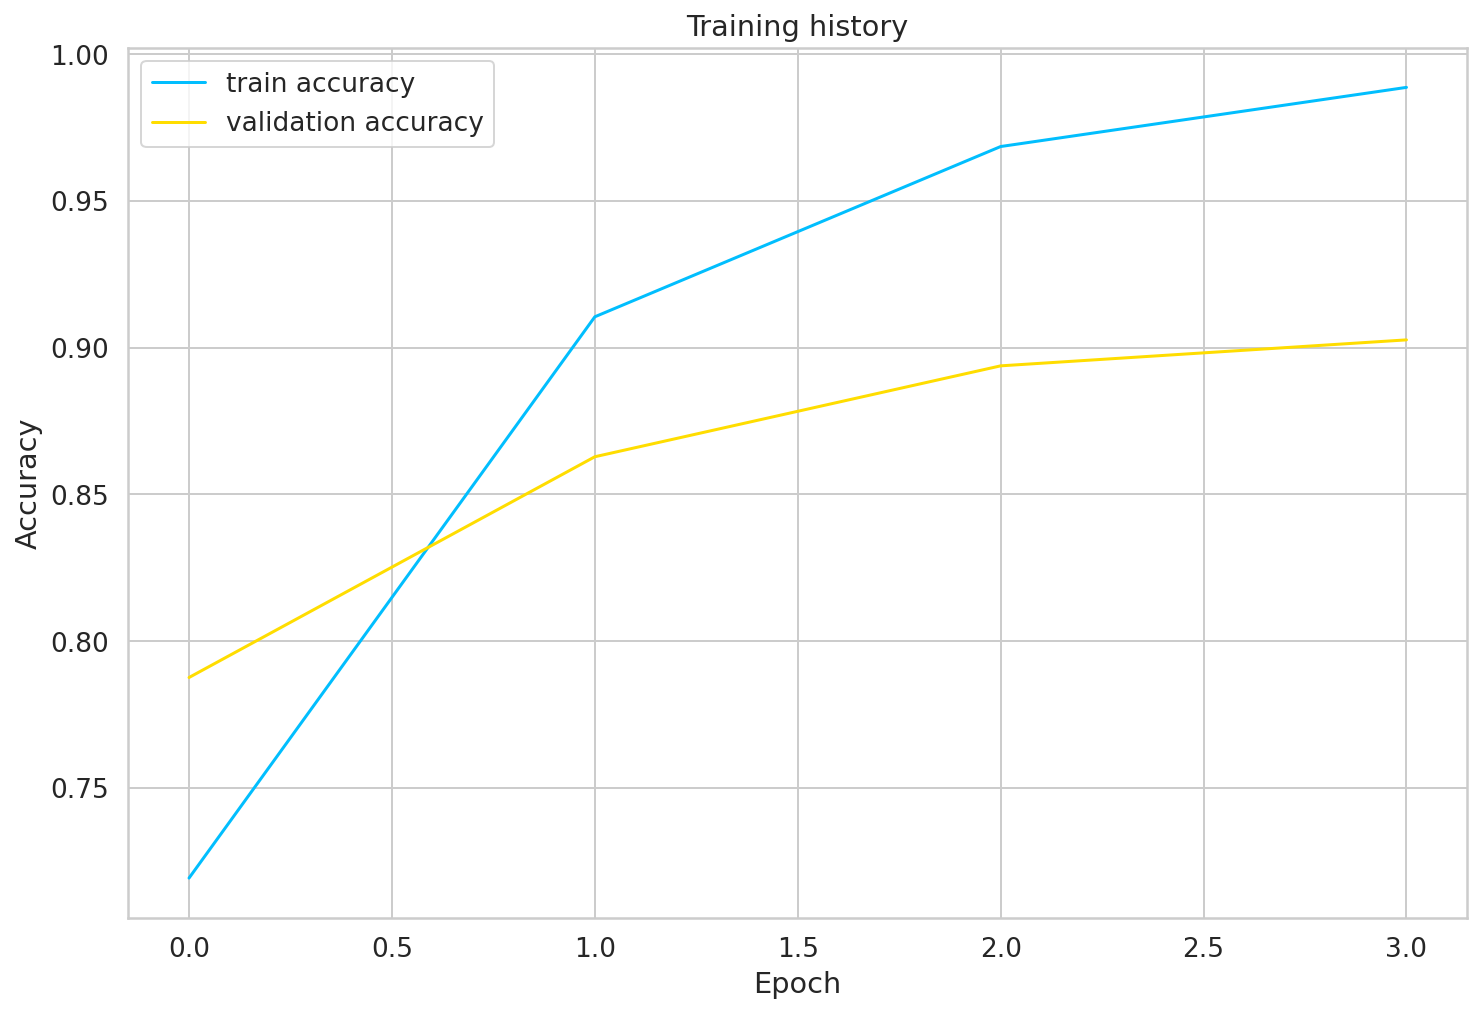

In [154]:
plt.plot(hist['train_acc'], label='train accuracy')
plt.plot(hist['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [155]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [156]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  train_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a

In [157]:
print(classification_report(y_test, y_pred, target_names=['not depression','moderate','severe']))

                precision    recall  f1-score   support

not depression       1.00      1.00      1.00       685
      moderate       0.99      0.99      0.99      1139
        severe       0.97      0.97      0.97       210

      accuracy                           0.99      2034
     macro avg       0.99      0.99      0.99      2034
  weighted avg       0.99      0.99      0.99      2034



In [158]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

In [161]:
print(classification_report(y_test, y_pred, target_names=['not depression','moderate','severe']))

                precision    recall  f1-score   support

not depression       0.96      0.84      0.90        82
      moderate       0.94      0.94      0.94       120
        severe       0.65      0.92      0.76        24

      accuracy                           0.90       226
     macro avg       0.85      0.90      0.87       226
  weighted avg       0.92      0.90      0.91       226

